<a href="https://colab.research.google.com/github/karimosabbagh/MAIS202/blob/main/MAIS_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAIS Project - Image classification

# Load Data from Kaggle

In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

# import shutil
# shutil.copytree('/content/drive/MyDrive/MAIS_Project/Data', '/content/dataset')
# data_dir = '/content/dataset'

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/MAIS_Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arnavr10880/concrete-crack-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/arnavr10880/concrete-crack-images-for-classification
License(s): Attribution 4.0 International (CC BY 4.0)
100% 233M/233M [00:10<00:00, 28.6MB/s]
100% 233M/233M [00:10<00:00, 24.4MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/concrete-crack-images-for-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
data_dir = '/content/dataset'

Import Libraries
==============================================


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import shutil
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold
from copy import deepcopy

# cudnn.benchmark = True
# plt.ion()   # interactive mode

Load Data
=========


In [ ]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# data_dir = '/content/drive/MyDrive/MAIS_Project/Data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

train_size = int(0.7 * len(dataset))   # 70% for training
val_size = int(0.15 * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
# Create DataLoaders for each split
dataloaders = {
    'train':train_loader,
    'val': val_loader,
    'test': test_loader
}

# Calculate dataset sizes for each split
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

# Get class names from the original dataset
class_names = dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(class_names)
print(device)

['Negative', 'Positive']
cpu


Visualize a few images
======================



In [1]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# # out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])
inputs, classes = next(iter(dataloaders['train']))

# Display each image in the batch individually
# for i in range(len(inputs)):
#     plt.figure()
#     imshow(inputs[i], title=class_names[classes[i]])
#     plt.show()

NameError: name 'dataloaders' is not defined

Training the model
==================

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     drive_save_path = '/content/drive/My Drive/MAIS_Project/best_model_params.pt'

#     # Create a temporary directory to save training checkpoints
#     with TemporaryDirectory() as tempdir:
#         best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

#         torch.save(model.state_dict(), best_model_params_path)
#         best_acc = 0.0

#         for epoch in range(num_epochs):
#             print(f'Epoch {epoch}/{num_epochs - 1}')
#             print('-' * 10)

#             # Each epoch has a training and validation phase
#             for phase in ['train', 'val']:
#                 if phase == 'train':
#                     model.train()  # Set model to training mode
#                 else:
#                     model.eval()   # Set model to evaluate mode

#                 running_loss = 0.0
#                 running_corrects = 0

#                 # Iterate over data.
#                 for inputs, labels in dataloaders[phase]:
#                     inputs = inputs.to(device)
#                     labels = labels.to(device)

#                     # zero the parameter gradients
#                     optimizer.zero_grad()

#                     # forward
#                     # track history if only in train
#                     with torch.set_grad_enabled(phase == 'train'):
#                         outputs = model(inputs)
#                         _, preds = torch.max(outputs, 1)
#                         loss = criterion(outputs, labels)

#                         # backward + optimize only if in training phase
#                         if phase == 'train':
#                             loss.backward()
#                             optimizer.step()

#                     # statistics
#                     running_loss += loss.item() * inputs.size(0)
#                     running_corrects += torch.sum(preds == labels.data)
#                 if phase == 'train':
#                     scheduler.step()

#                 epoch_loss = running_loss / dataset_sizes[phase]
#                 epoch_acc = running_corrects.double() / dataset_sizes[phase]

#                 print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#                 # deep copy the model
#                 if phase == 'val' and epoch_acc > best_acc:
#                     best_acc = epoch_acc
#                     torch.save(model.state_dict(), best_model_params_path)
#                     shutil.copy(best_model_params_path, drive_save_path)

#             print()

#         time_elapsed = time.time() - since
#         print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#         print(f'Best val Acc: {best_acc:4f}')

#         # load best model weights
#         model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
#     return model

In [ ]:
def train_model(model, criterion, optimizer, scheduler,  dataloaders, dataset_sizes, device, num_epochs=11):
    since = time.time()

    drive_save_path = '/content/drive/My Drive/MAIS_Project/best_model_params.pt'

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # metrics
        train_losses = []
        val_losses = []
        val_precision = []
        val_recall = []
        val_f1 = []
        val_accuracies = []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    if phase == 'val':
                      all_preds.extend(preds.cpu().numpy())
                      all_labels.extend(labels.cpu().numpy())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                  train_losses.append(epoch_loss)
                else:
                  val_losses.append(epoch_loss)
                  val_accuracies.append(epoch_acc.item())

                  precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
                  recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
                  f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

                  val_precision.append(precision)
                  val_recall.append(recall)
                  val_f1.append(f1)

                  print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    shutil.copy(best_model_params_path, drive_save_path)




            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, best_acc, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'precision': val_precision,
        'recall': val_recall,
        'f1': val_f1
    }

In [ ]:
def k_fold_cross_validation(model, dataset, criterion, optimizer_fn, scheduler_fn, k=5, num_epochs=11, batch_size=32, device='cpu'):

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'train_losses': [],
        'val_losses': [],
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold+1}/{k}')
        print('-' * 20)

        # Create training and validation subsets
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        # Create dataloaders for training and validation
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        dataloaders = {
            'train': train_loader,
            'val': val_loader
        }
        dataset_sizes = {
            'train': len(train_subset),
            'val': len(val_subset)
        }

        # Initialize a new model instance for this fold
        model = deepcopy(model).to(device)

        # Define optimizer and scheduler for this fold
        optimizer = optimizer_fn(model.parameters())
        scheduler = scheduler_fn(optimizer)

        # Train the model for this fold
        trained_model, best_acc, metrics = train_model(
            model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs
        )

        # Collect metrics
        fold_results['accuracy'].append(np.max(metrics['val_accuracies']))
        fold_results['precision'].append(np.mean(metrics['precision']))
        fold_results['recall'].append(np.mean(metrics['recall']))
        fold_results['f1'].append(np.mean(metrics['f1']))
        fold_results['train_losses'].append(metrics['train_losses'])
        fold_results['val_losses'].append(metrics['val_losses'])

        print(f'Fold {fold+1} Best Accuracy: {fold_results["accuracy"][-1]:.4f}')
        print(f'Precision: {fold_results["precision"][-1]:.4f}, Recall: {fold_results["recall"][-1]:.4f}, F1-Score: {fold_results["f1"][-1]:.4f}')
        print()

    # Average metrics across folds
    print(f'K-Fold Cross Validation Results:')
    print(f'Mean Accuracy: {np.mean(fold_results["accuracy"]):.4f}')
    print(f'Mean Precision: {np.mean(fold_results["precision"]):.4f}')
    print(f'Mean Recall: {np.mean(fold_results["recall"]):.4f}')
    print(f'Mean F1-Score: {np.mean(fold_results["f1"]):.4f}')

    # Return metrics
    return fold_results


Visualizing the model predictions
======================

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor
==================================


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


Train and evaluate
==================

In [ ]:
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25)

train_val_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
results = k_fold_cross_validation(
    model=model_conv,
    dataset= train_val_dataset,
    criterion=criterion,
    optimizer_fn= lambda params: optim.SGD(params, lr=0.001, momentum=0.9),
    scheduler_fn= lambda optimizer: lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
    k=5,
    num_epochs=6,
    batch_size=32,
    device=device
)


Fold 1/5
--------------------
Epoch 0/5
----------
train Loss: 0.0855 Acc: 0.9760
val Loss: 0.0276 Acc: 0.9940
Precision: 0.9940, Recall: 0.9940, F1-Score: 0.9940

Epoch 1/5
----------
train Loss: 0.0383 Acc: 0.9886
val Loss: 0.0182 Acc: 0.9959
Precision: 0.9959, Recall: 0.9959, F1-Score: 0.9959

Epoch 2/5
----------
train Loss: 0.0337 Acc: 0.9897
val Loss: 0.0188 Acc: 0.9953
Precision: 0.9953, Recall: 0.9953, F1-Score: 0.9953

Epoch 3/5
----------
train Loss: 0.0308 Acc: 0.9901
val Loss: 0.0152 Acc: 0.9963
Precision: 0.9963, Recall: 0.9963, F1-Score: 0.9963

Epoch 4/5
----------
train Loss: 0.0283 Acc: 0.9910
val Loss: 0.0127 Acc: 0.9966
Precision: 0.9966, Recall: 0.9966, F1-Score: 0.9966

Epoch 5/5
----------
train Loss: 0.0272 Acc: 0.9915
val Loss: 0.0122 Acc: 0.9965
Precision: 0.9965, Recall: 0.9965, F1-Score: 0.9965

Training complete in 12m 16s
Best val Acc: 0.996618
Fold 1 Best Accuracy: 0.9966
Precision: 0.9958, Recall: 0.9958, F1-Score: 0.9958

Fold 2/5
--------------------
Ep

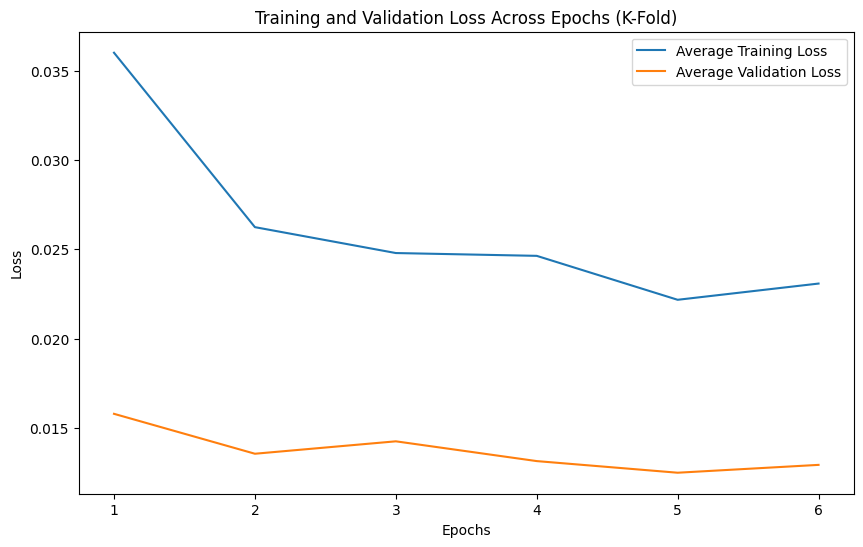

In [ ]:
# visualize_model(model_conv)

# plt.ioff()
# plt.show()

avg_train_losses = np.mean(results['train_losses'], axis=0)
avg_val_losses = np.mean(results['val_losses'], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label='Average Training Loss')
plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs (K-Fold)')
plt.legend()
plt.show()

Prediction on testing set
==========================



In [ ]:
drive_save_path = '/content/drive/My Drive/MAIS_Project/best_model_params.pt'
model_conv.load_state_dict(torch.load(drive_save_path, map_location=torch.device('cpu')))
model_conv.eval()

<ipython-input-15-4c8d6733d7c7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_conv.load_state_dict(torch.load(drive_save_path, map_location=torch.device('cpu')))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def evaluate_model_on_test_set(model, test_loader, device):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy, precision, recall, f1 = evaluate_model_on_test_set(model_conv, test_loader, device)

Test Accuracy: 0.9972
Test Precision: 0.9972
Test Recall: 0.9972
Test F1-Score: 0.9972


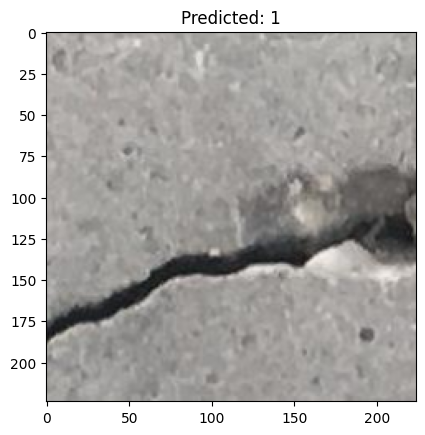

True Label: 1, Predicted Label: 1


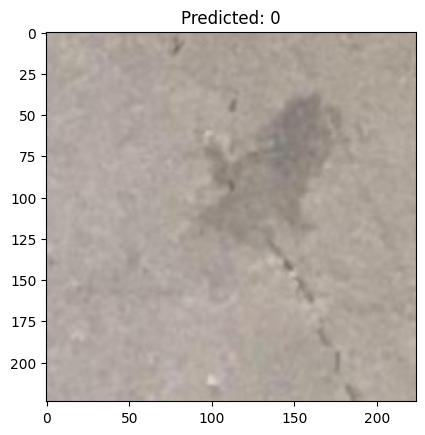

True Label: 0, Predicted Label: 0


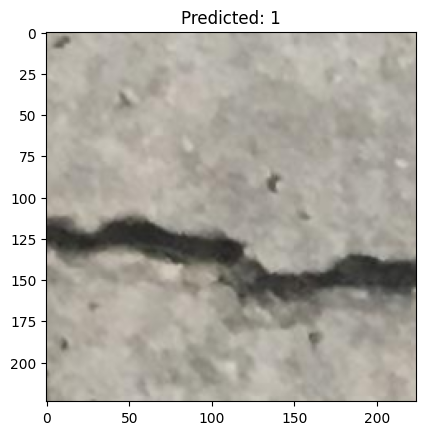

True Label: 1, Predicted Label: 1


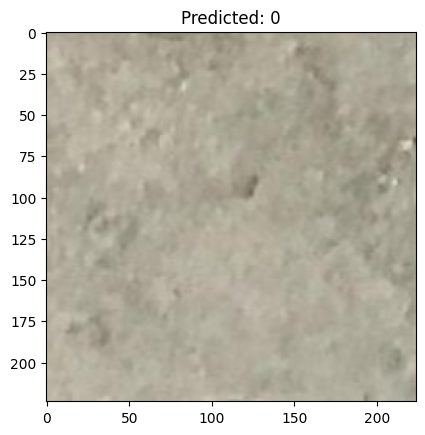

True Label: 0, Predicted Label: 0


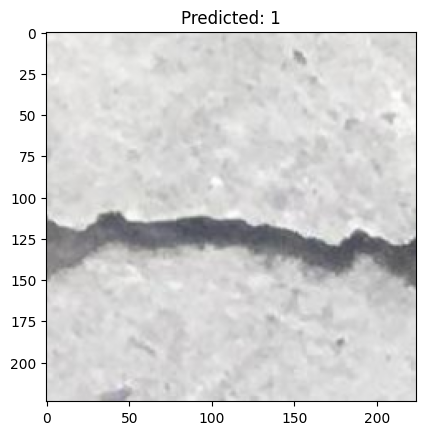

True Label: 1, Predicted Label: 1


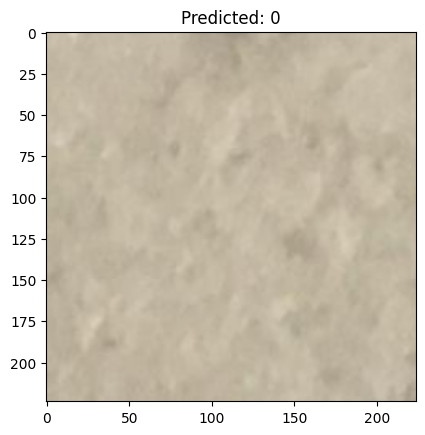

True Label: 0, Predicted Label: 0


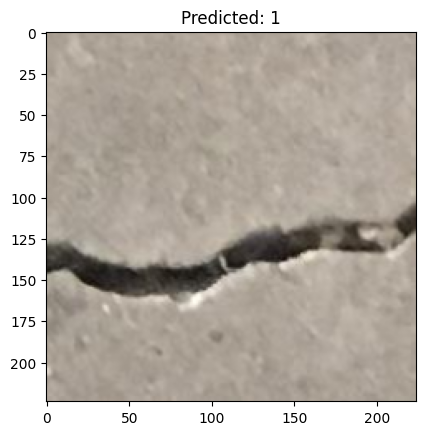

True Label: 1, Predicted Label: 1


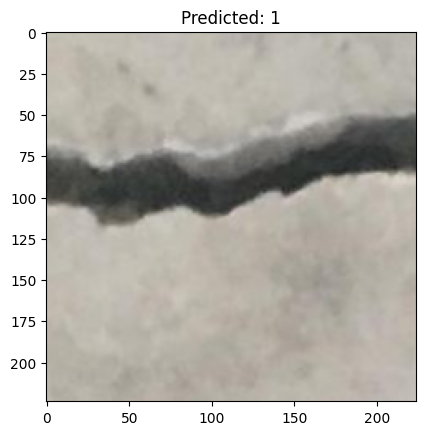

True Label: 1, Predicted Label: 1


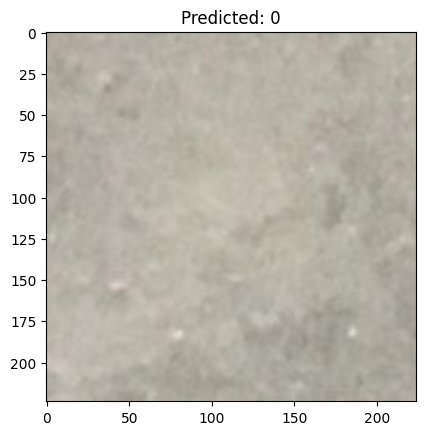

True Label: 0, Predicted Label: 0


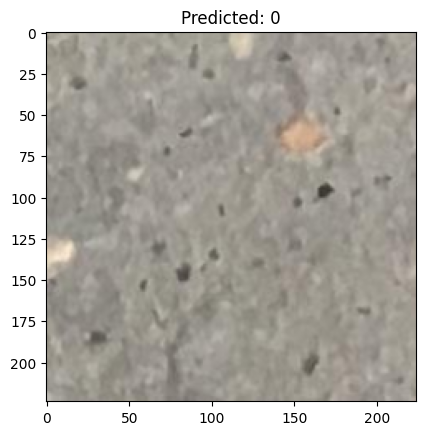

True Label: 0, Predicted Label: 0


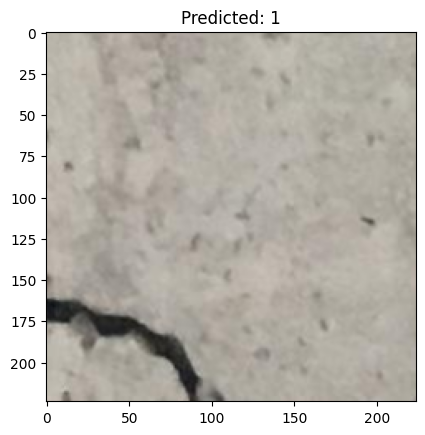

True Label: 1, Predicted Label: 1


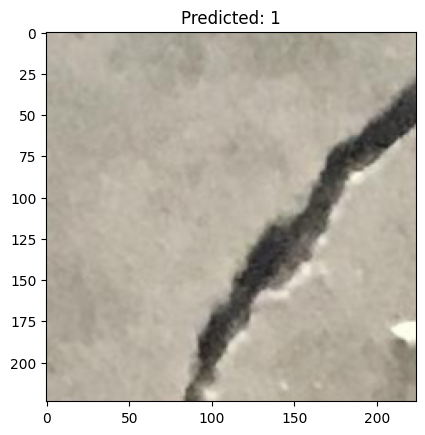

True Label: 1, Predicted Label: 1


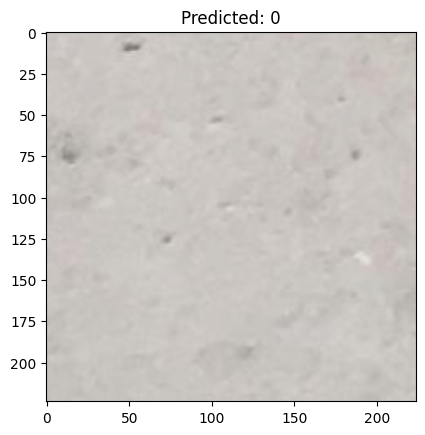

True Label: 0, Predicted Label: 0


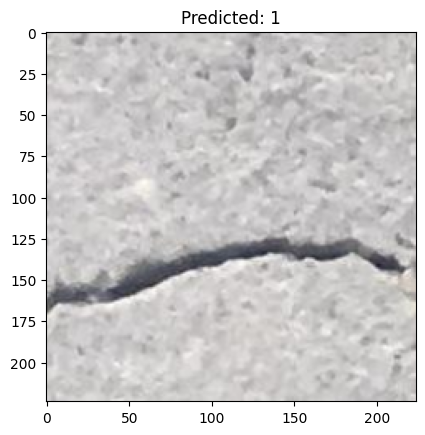

True Label: 1, Predicted Label: 1


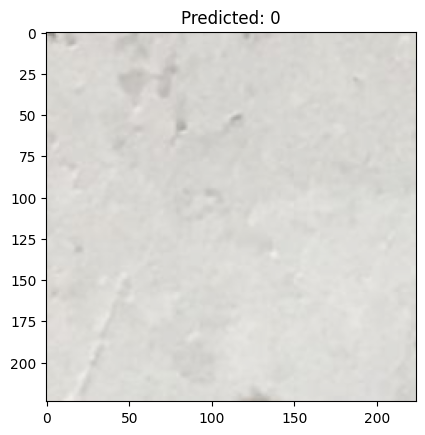

True Label: 0, Predicted Label: 0


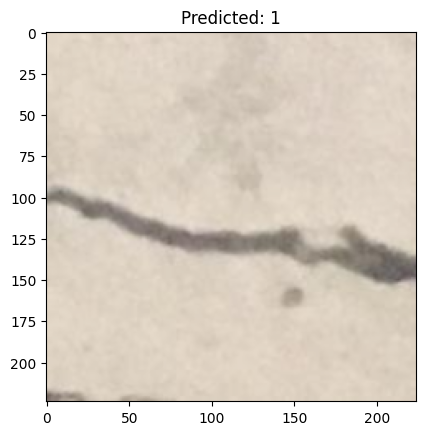

True Label: 1, Predicted Label: 1


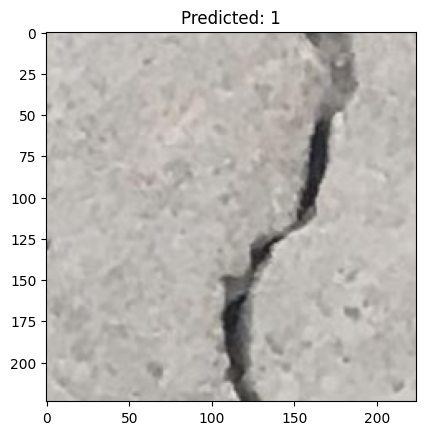

True Label: 1, Predicted Label: 1


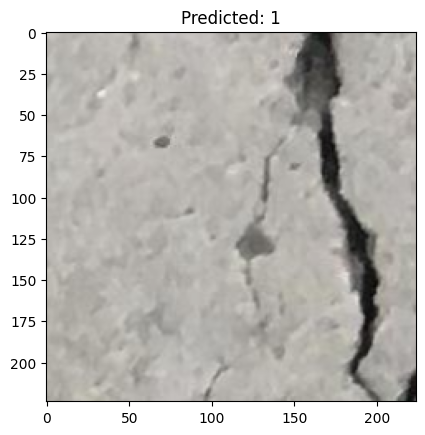

True Label: 1, Predicted Label: 1


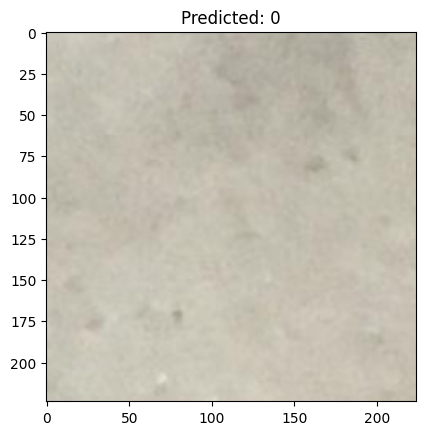

True Label: 0, Predicted Label: 0


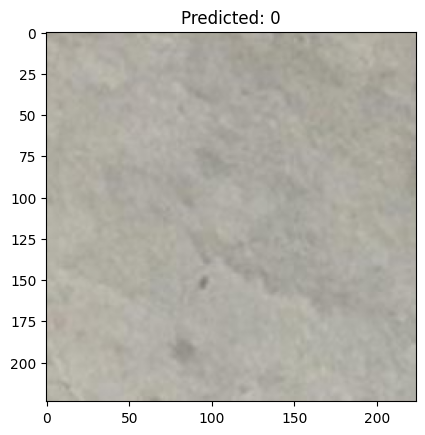

True Label: 0, Predicted Label: 0


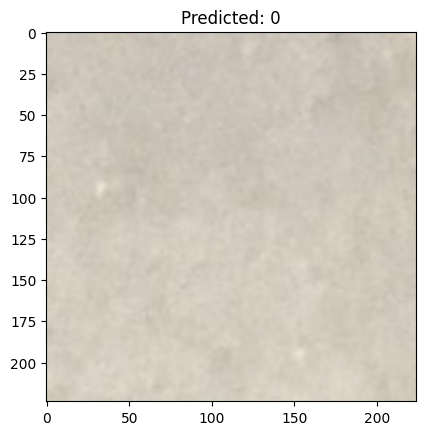

True Label: 0, Predicted Label: 0


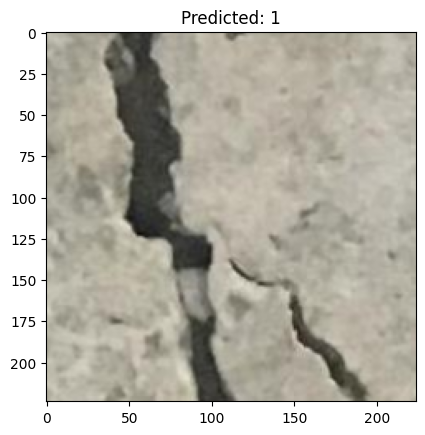

True Label: 1, Predicted Label: 1


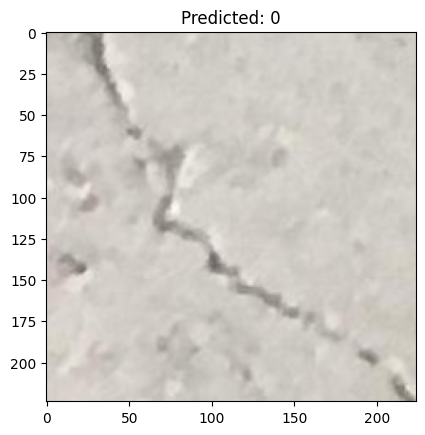

True Label: 1, Predicted Label: 0


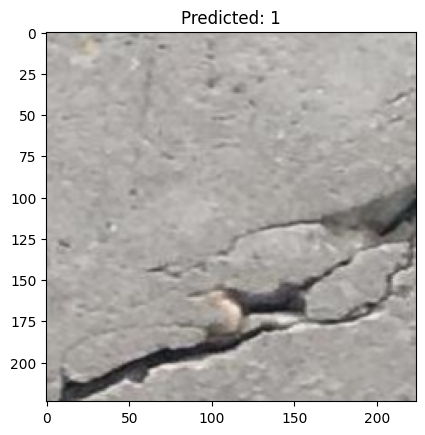

True Label: 1, Predicted Label: 1


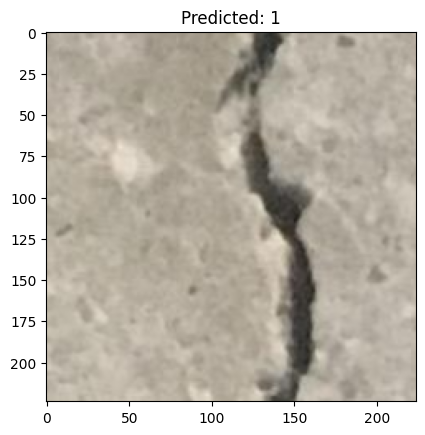

True Label: 1, Predicted Label: 1


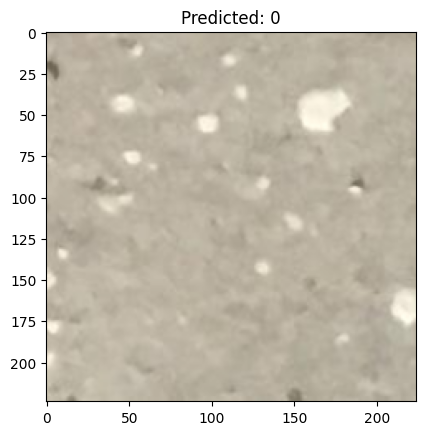

True Label: 0, Predicted Label: 0


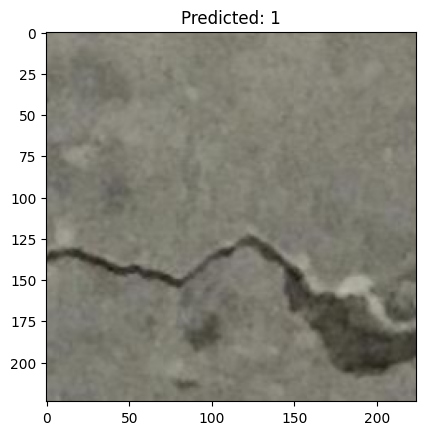

True Label: 1, Predicted Label: 1


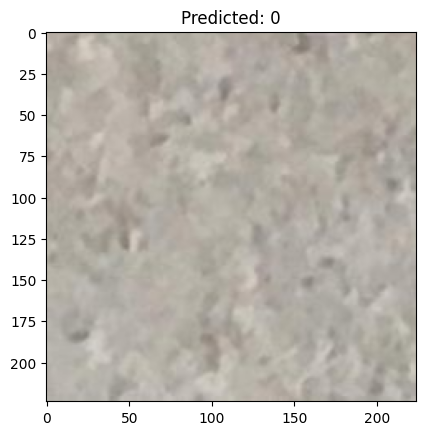

True Label: 0, Predicted Label: 0


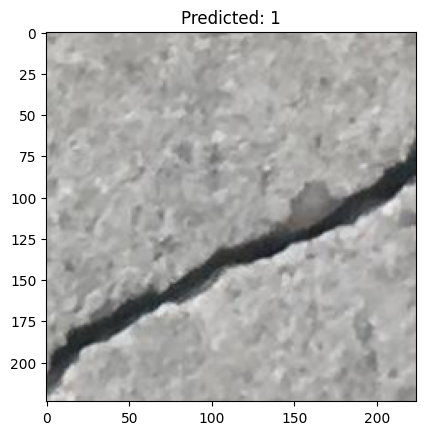

True Label: 1, Predicted Label: 1


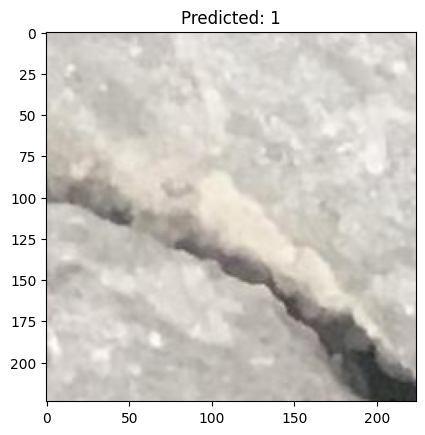

True Label: 1, Predicted Label: 1


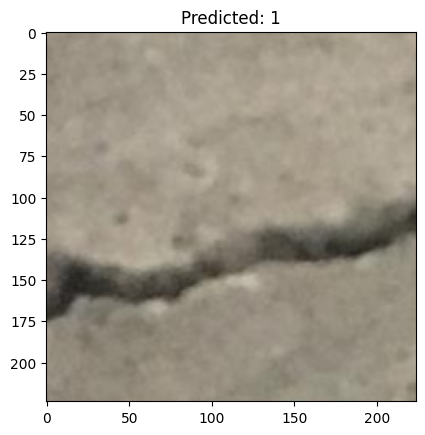

True Label: 1, Predicted Label: 1


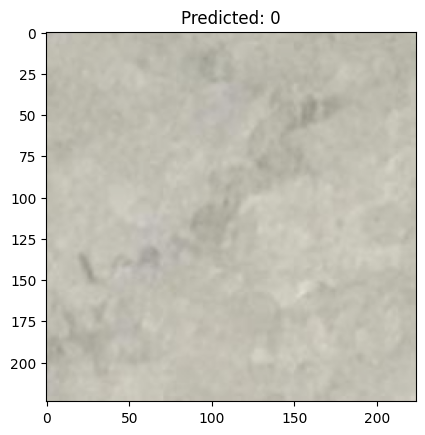

True Label: 0, Predicted Label: 0


In [ ]:
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Get model predictions
    outputs = model_conv(inputs)
    _, preds = torch.max(outputs, 1)

    # Loop through the batch and display each image with its prediction
    for j in range(inputs.size(0)):
        plt.figure()
        if preds[j].item() == 1:
          prediction = 'Positive'
        else:
          prediction = 'Negative'
        imshow(inputs[j].cpu(), title=f"Predicted: {prediction}")
        plt.show()
        # print(f"True Label: {labels[j].item()}, Predicted Label: {preds[j].item()}")


    break